In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing librares

In [2]:
import sys
sys.path.append("../src/")

In [3]:
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import collections
from tqdm import tqdm
from gensim.models import word2vec

from textDataset import *
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import calinski_harabaz_score
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud,STOPWORDS
from scipy.stats import norm

In [6]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


# Text preprocessing

In [7]:
#path2data = '../../'
path2data = '../data/news_headlines/'

text = {
        'train': TextDataset(path2data, extension='.csv', sep=',', is_train = True),
}    

In [8]:
col = 'headline_text'
text['train'].process_data(col = col, remove_stopw = True, remove_tags=False, lemmalize = True, stem = True)

In [9]:
print('Dataset lenght: {}'.format(len(text['train'].data)))

Dataset lenght: 643715


In [10]:
text['train'].data.publish_date = pd.to_datetime(text['train'].data.publish_date.astype(str),format='%Y-%m-%d')

In [11]:
text['train'].data.head()

,publish_date,headline_text,subject,headline_text_data,nb_words
0,2003-03-03,unhooked brakes to blame for taiwan train disa...,news_headlines,"[unhook, brake, blame, taiwan, train, disast]",6
1,2003-09-18,oldest prisoner in tas released citing health,news_headlines,"[oldest, prison, ta, releas, cite, health]",6
5,2003-06-01,tougher water restrictions loom after dry may,news_headlines,"[tougher, water, restrict, loom, dri, may]",6
7,2003-07-23,minardi sign italian bruni as test driver,news_headlines,"[minardi, sign, italian, bruni, test, driver]",6
8,2003-09-10,man breaks leg in cliff fall,news_headlines,"[man, break, leg, cliff, fall]",5


In [12]:
text['train'].data.publish_date.describe()

count                  643715
unique                   5422
top       2012-08-14 00:00:00
freq                      238
first     2003-02-19 00:00:00
last      2017-12-31 00:00:00
Name: publish_date, dtype: object

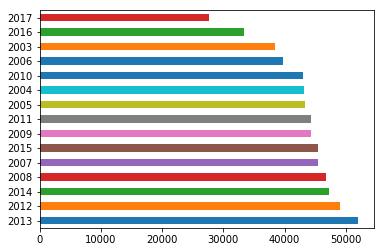

In [13]:
text['train'].data.publish_date.dt.year.value_counts().plot(kind = 'barh')

# Extracting Features

In [14]:
def buildWordVector(model, tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size))
            count += 1.
        except KeyError: 
            continue
    return vec

In [15]:
features_extractor = 'word2Vec'
#features_extractor = 'bow'

In [16]:
def extract_features(X_train, features_extractor = 'word2Vec', max_gram = 2):

    print('Features extractor: {}'.format(features_extractor))

    if features_extractor == 'bow':

        print('Counting ocorrences of words. Ngram-range: {}...'.format(str((1,max_gram))))
        vectorizer = CountVectorizer(analyzer = "word",
                                     max_features = 300, ngram_range=(1,max_gram)) 
        f_train = vectorizer.fit_transform([" ".join(x) for x in X_train])

        #downscale weights for words using tf–idf: “Term Frequency times Inverse Document Frequency”.
        print('Words downscaling using TF-IDF...')

        tfidf_transformer = TfidfTransformer()
        f_train = tfidf_transformer.fit_transform(f_train)
        
        model = vectorizer

    else:

        # Set values for various parameters
        num_features = 300    # Word vector dimensionality                      
        min_word_count = 50   # Minimum word count                        
        num_workers = cpu_count  # Number of threads to run in parallel
        context = 10          # Context window size                                                                                    
        downsampling = 1e-3   # Downsample setting for frequent words (default value)


        print('Creating Word2Vec Model...')
        W2Vmodel = word2vec.Word2Vec(workers=num_workers, \
                    size=num_features, min_count = min_word_count, \
                    window = context, sample = downsampling)

        corpus = [x for x in X_train]
        W2Vmodel.build_vocab(corpus)
        W2Vmodel.train(corpus, \
                    total_examples=W2Vmodel.corpus_count, epochs=W2Vmodel.epochs)

        f_train = np.concatenate([buildWordVector(W2Vmodel, z, num_features) for z in map(lambda x: x, X_train)])
        
        scaler = StandardScaler()
        f_train = scaler.fit_transform(f_train)
        
        model = W2Vmodel
        
    return f_train, model

### Find number of clusters

In [17]:
def find_nb_clusters(f_train, kmax = 25, plot=True):
    wcss = []
    cali = []
    
    print('Max number of clusters for MiniBatchKMeans: {}'.format(kmax))
    for i in tqdm(range(2, kmax)):
        kmeans = MiniBatchKMeans(n_clusters = i, init = 'k-means++',
                                 n_init=1,init_size= int(1e3),
                                 random_state = 42,batch_size=int(1e3))
        kmeans.fit(f_train)
        wcss.append(kmeans.inertia_)
        ypred = kmeans.predict(f_train)
        cali.append(calinski_harabaz_score(f_train,ypred))
        
    if plot:

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(2, kmax), cali, '-o')
        plt.title('Calinski Harabaz Score')
        plt.xlabel('Number of clusters')
        plt.ylabel('Score')
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(range(2, kmax), wcss, '-o')
        plt.title('The Elbow Method (WCSS)')
        plt.xlabel('Number of clusters')
        plt.ylabel('Score')
        plt.grid()
        
        plt.show()
    return wcss, cali

# Quantitative Cluster Analysis

In [18]:
def calculate_cluster_variance(f_train, n_clusters=4):

    kmeans = MiniBatchKMeans(n_clusters = n_clusters, init = 'k-means++',
                                 n_init=1,init_size= int(1e3),
                                 random_state = 42,batch_size=int(1e3))
    kmeans.fit(f_train)
        
    ypred = kmeans.predict(f_train)

    #np.unique(ypred,return_counts=True)
    tmp =np.concatenate([f_train,ypred.reshape(-1,1)],axis=1)
    var=[]
    for cluster in range(n_clusters): 
        var.append(np.var(tmp[tmp[:,-1]==cluster]))

    return var

# Qualitative Cluster Analysis

In [19]:
def get_corpus(data):
    corpus = []
    for i in data:
        for j in i:
            corpus.append(j)
    return corpus    

In [20]:
def get_wordCloud(corpus):
    
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str(corpus))
    return wordCloud

In [21]:
def count_most_frequent_words(corpus, n_print = 5):

    word_counter = collections.Counter(procTextCorpus)
    for word, count in word_counter.most_common(n_print):
        print(word, ": ", count)
    return word_counter

In [22]:
directory_lst = ['./figs/elbow/', './figs/qualitative_analysis/',
                 './figs/quantitative_analysis/']
for directory in directory_lst:    
    if not os.path.exists(directory):
        os.makedirs(directory)

## Cluster analysis for each year

Dataset length: 38396. Year: 2003
Features extractor: word2Vec
Creating Word2Vec Model...


/home/renatolr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:09<00:00,  1.82it/s]


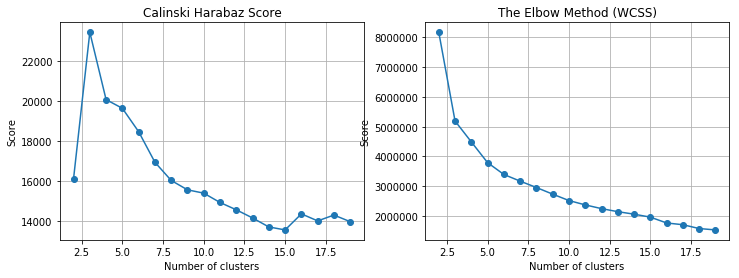

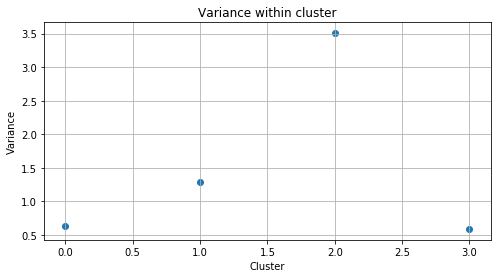

u :  1485
polic :  1343
govt :  1221
plan :  1160
new :  1082


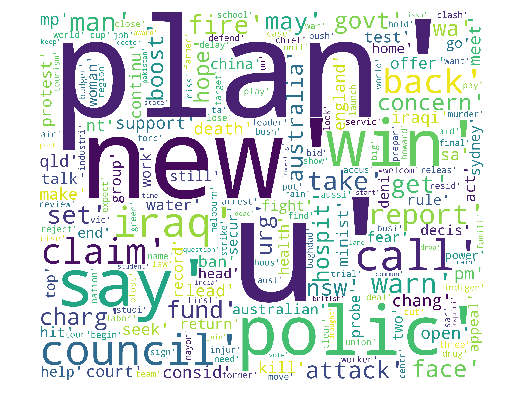

Dataset length: 43179. Year: 2004
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


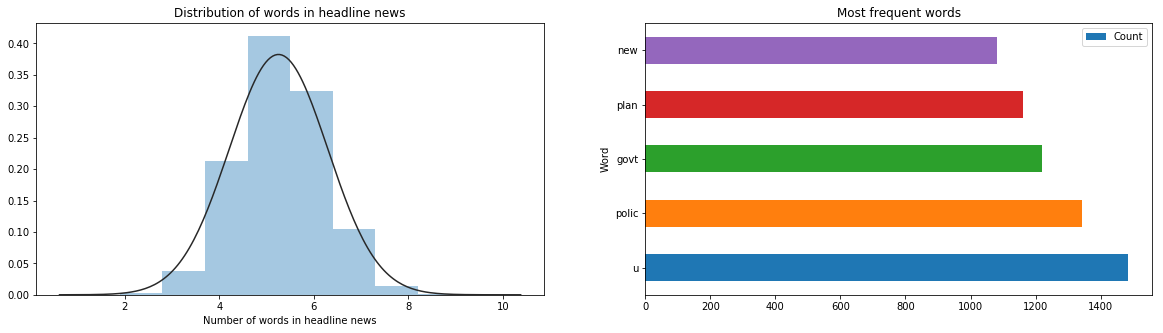

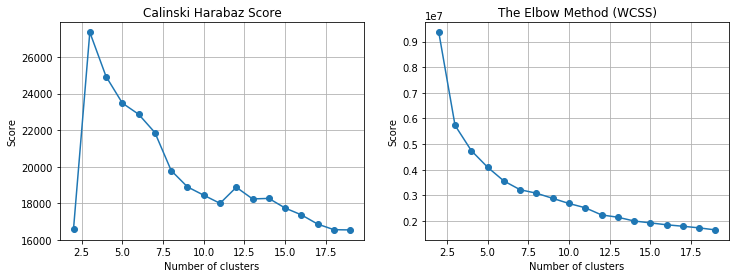

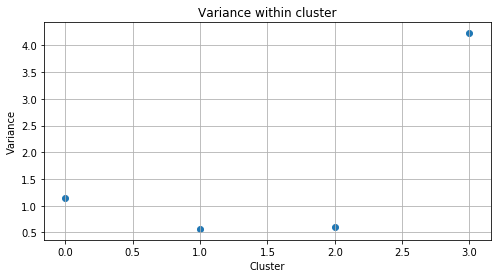

polic :  1630
plan :  1327
u :  1319
govt :  1256
new :  1193


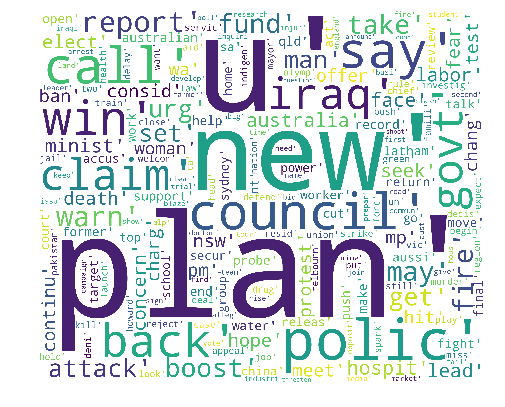

Dataset length: 43351. Year: 2005
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:15<00:00,  1.13it/s]


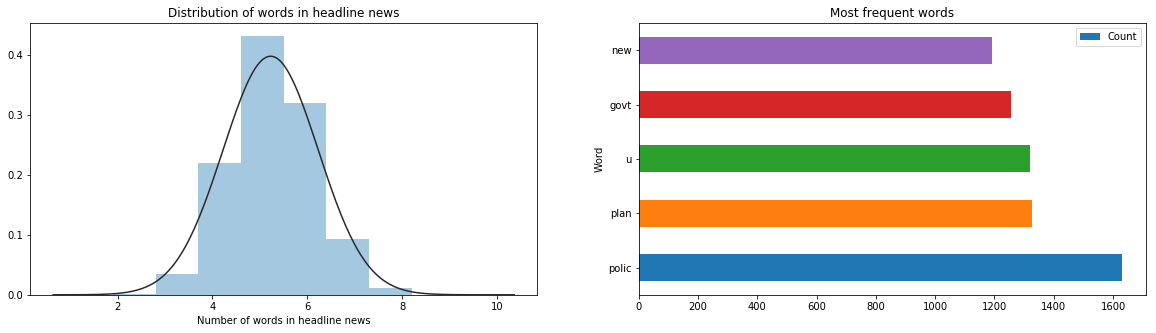

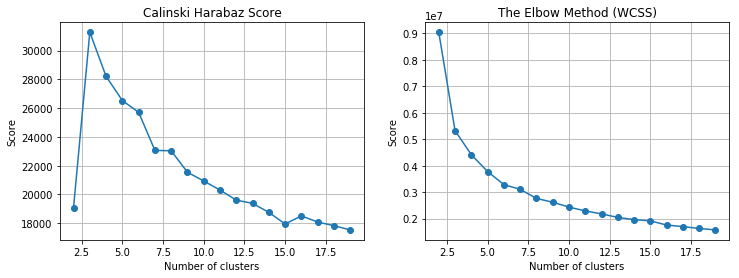

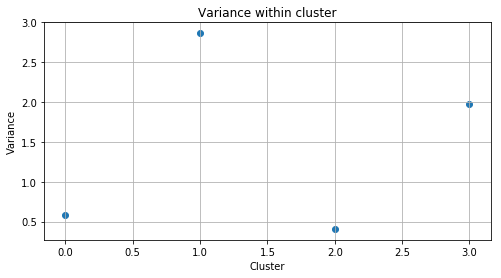

polic :  1693
govt :  1560
plan :  1298
new :  1246
council :  1109


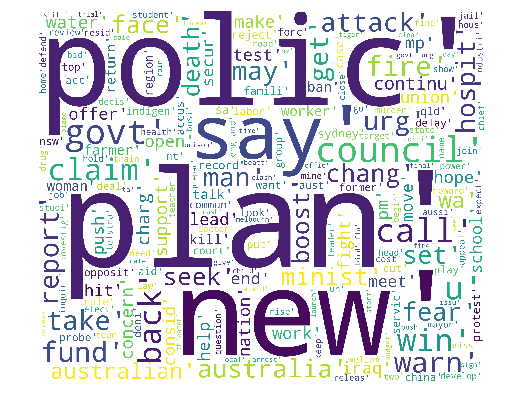

Dataset length: 39694. Year: 2006
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:08<00:00,  2.24it/s]


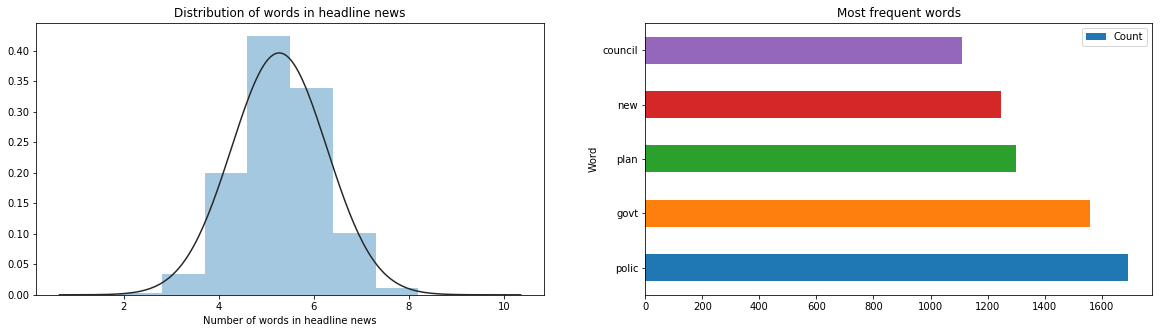

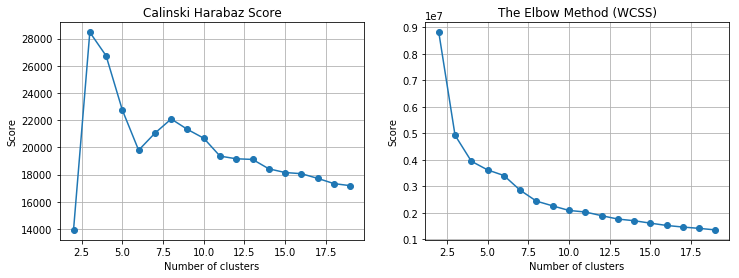

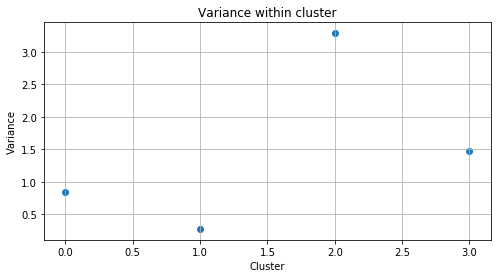

polic :  1432
govt :  1422
plan :  1123
new :  1059
urg :  956


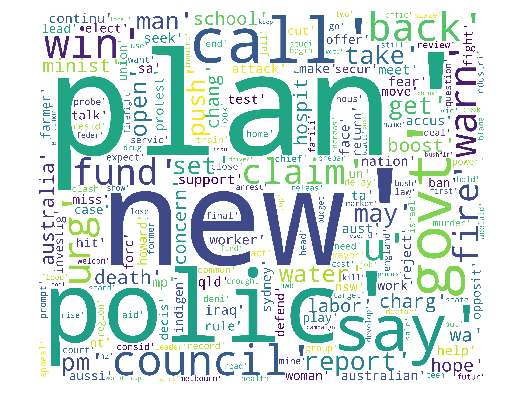

Dataset length: 45448. Year: 2007
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


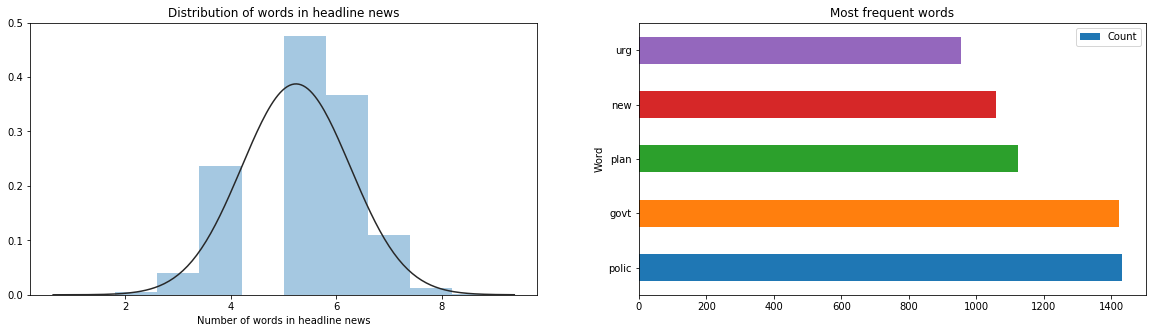

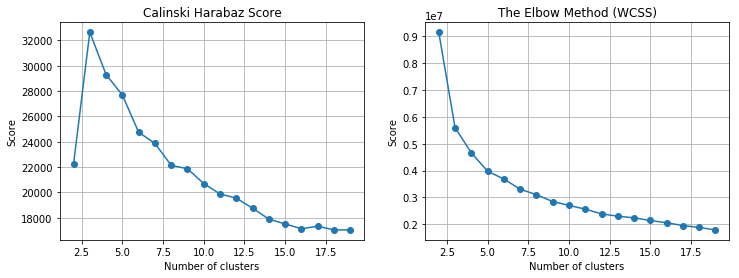

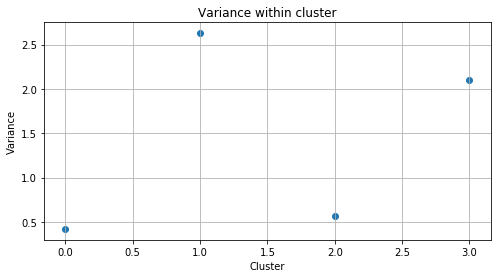

polic :  1990
govt :  1699
man :  1241
new :  1191
say :  1187


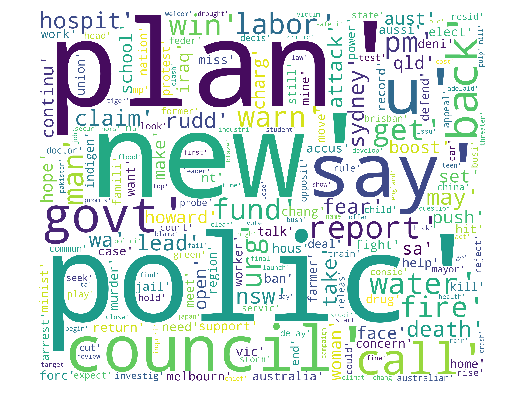

Dataset length: 46806. Year: 2008
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


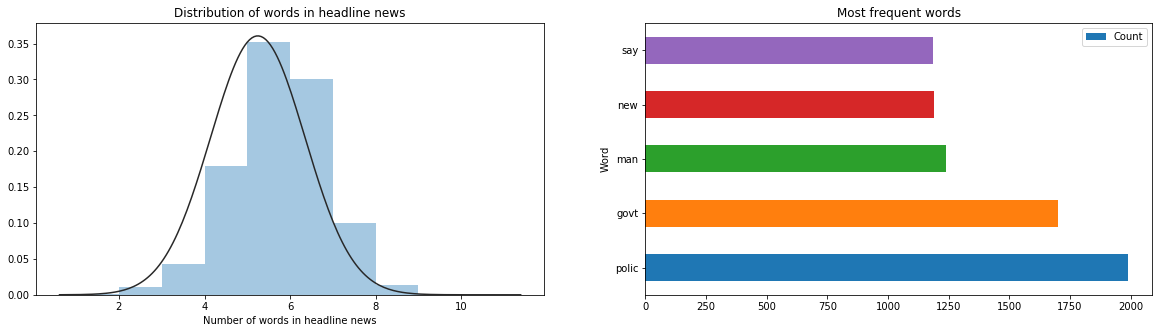

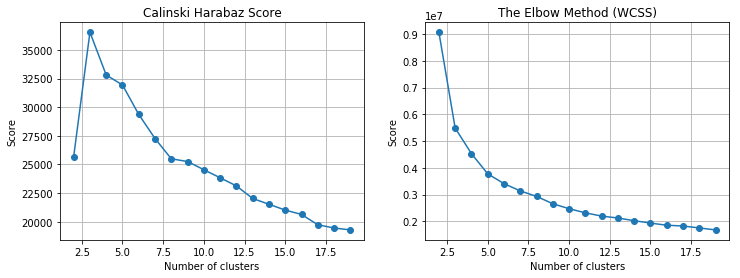

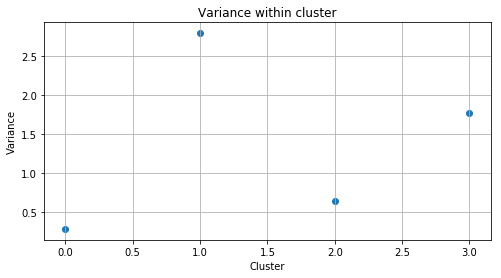

polic :  1865
govt :  1560
man :  1402
new :  1176
charg :  999


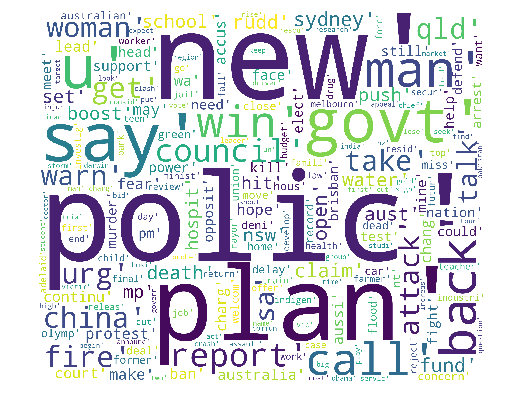

Dataset length: 44401. Year: 2009
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


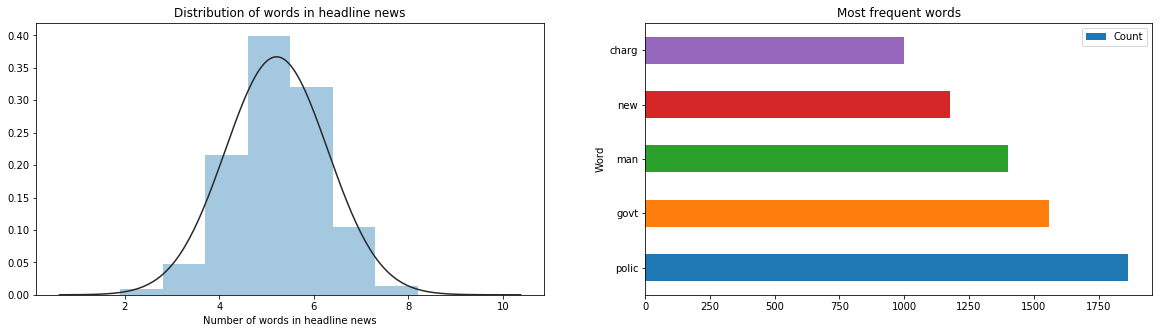

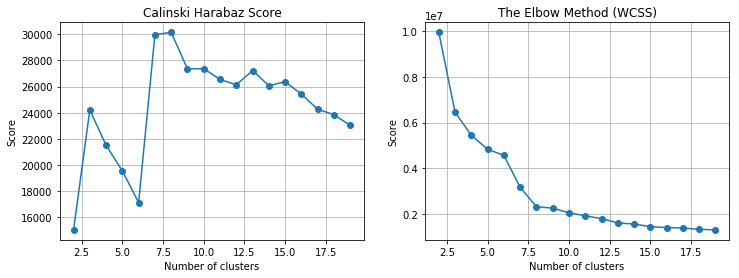

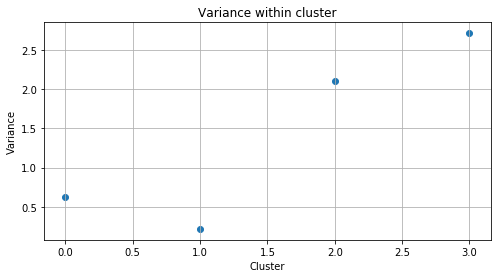

polic :  1541
man :  1250
new :  1023
fire :  947
charg :  897


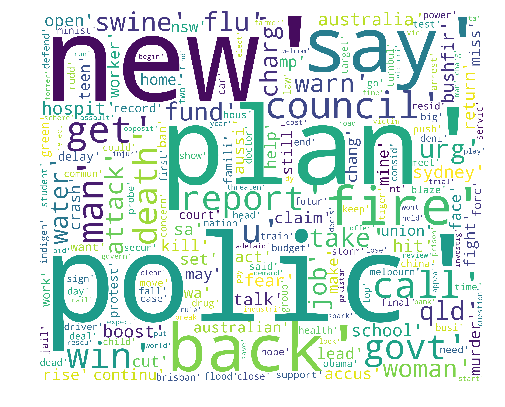

Dataset length: 43088. Year: 2010
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:12<00:00,  1.50it/s]


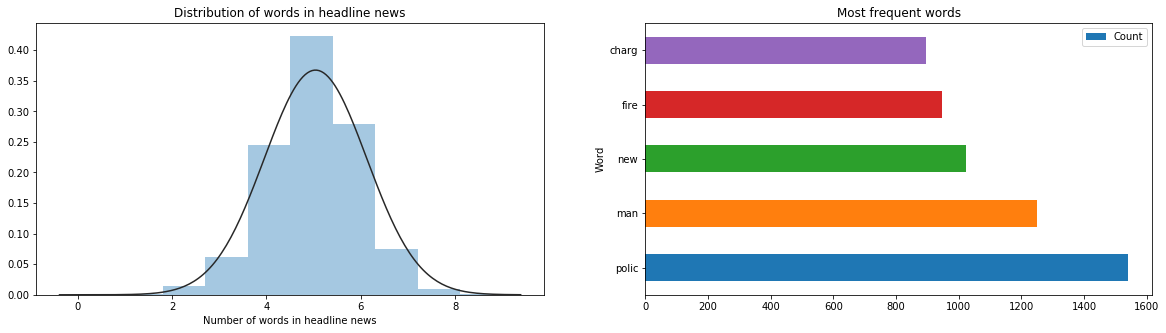

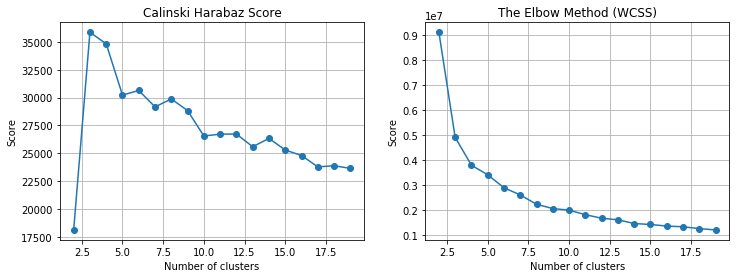

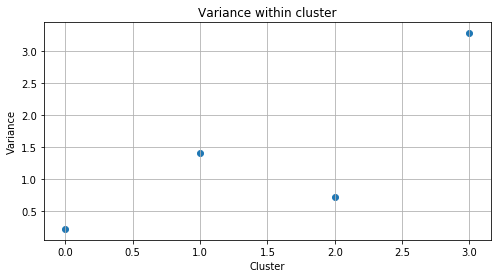

man :  1392
polic :  1389
new :  983
charg :  882
plan :  879


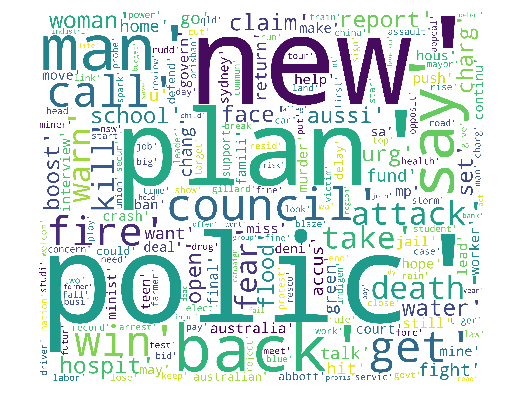

Dataset length: 44387. Year: 2011
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:11<00:00,  1.56it/s]


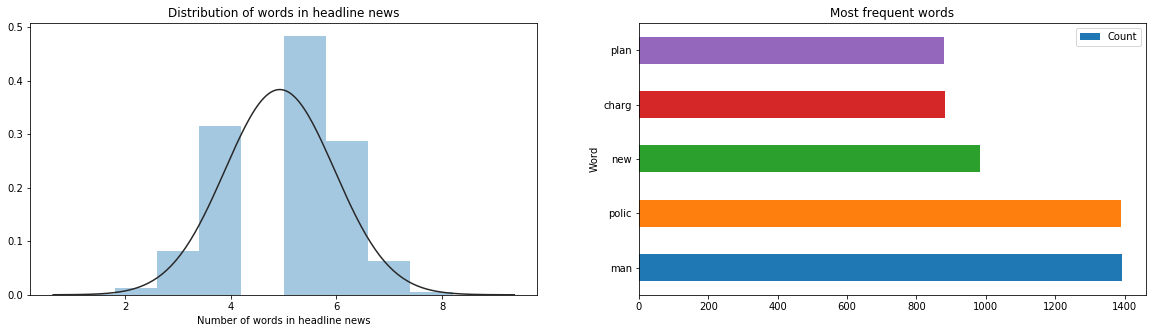

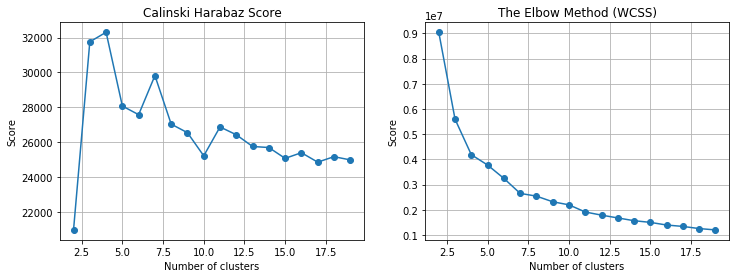

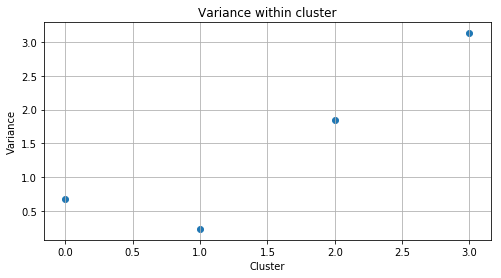

polic :  1242
man :  1195
flood :  1156
new :  1059
call :  809


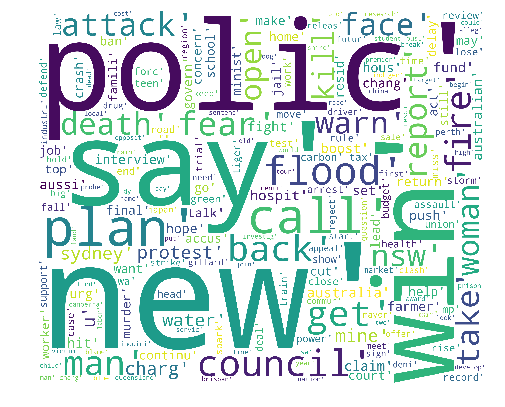

Dataset length: 49132. Year: 2012
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:14<00:00,  1.21it/s]


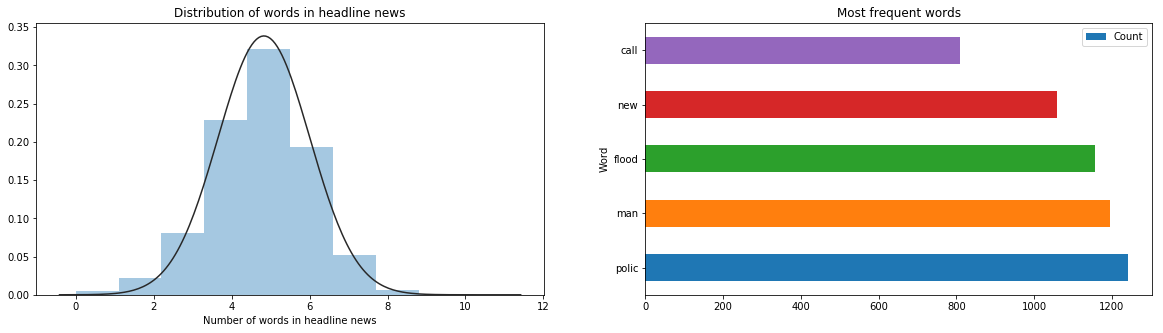

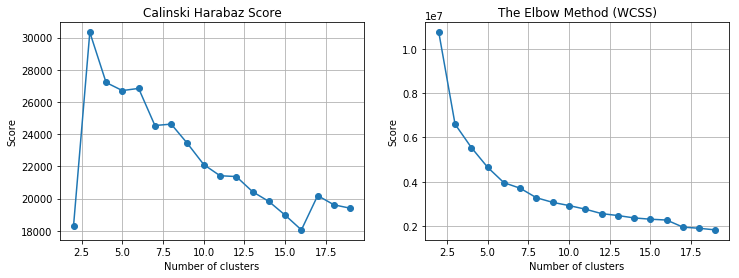

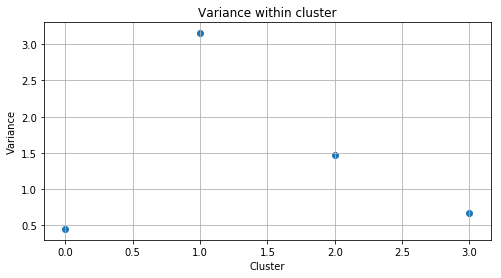

polic :  1308
man :  1194
new :  1190
plan :  848
say :  844


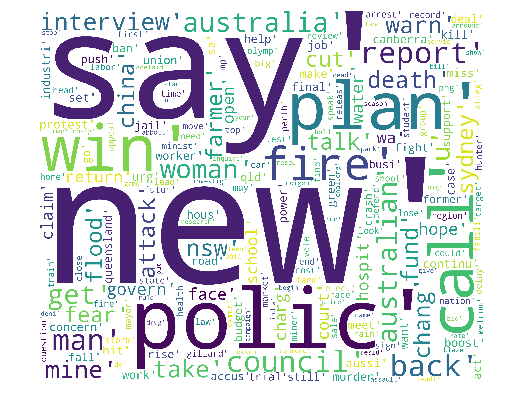

Dataset length: 52068. Year: 2013
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:16<00:00,  1.11it/s]


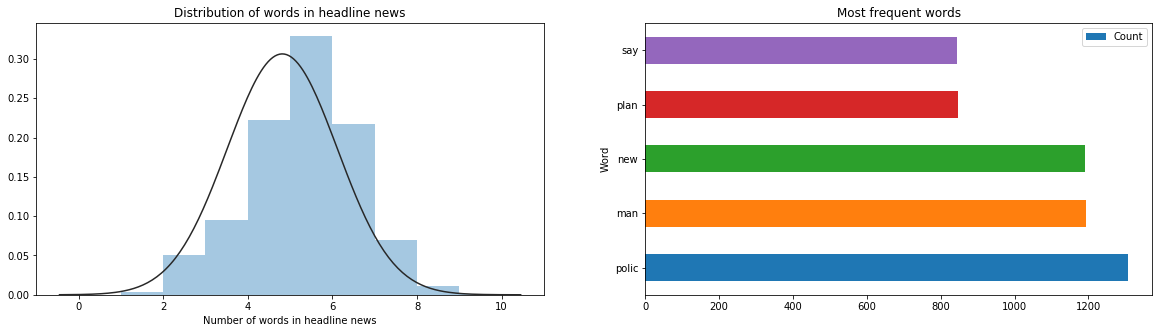

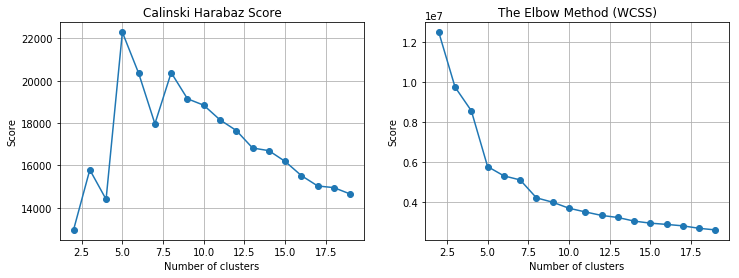

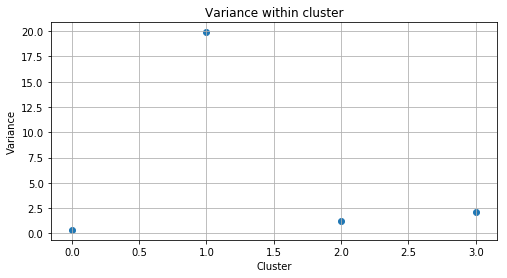

new :  1473
polic :  1430
man :  1385
say :  1117
fire :  959


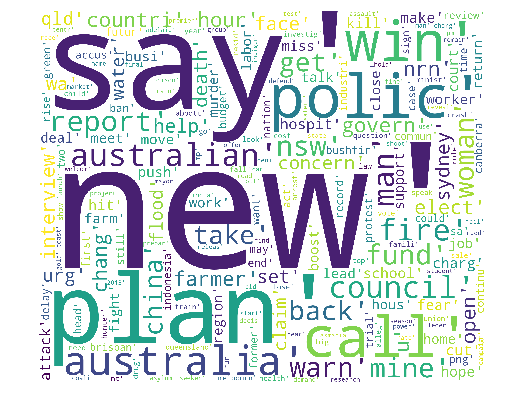

Dataset length: 47234. Year: 2014
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:10<00:00,  1.73it/s]


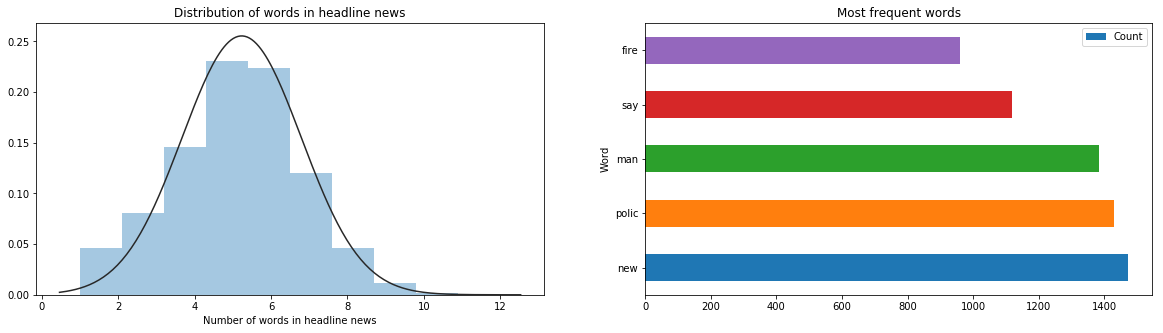

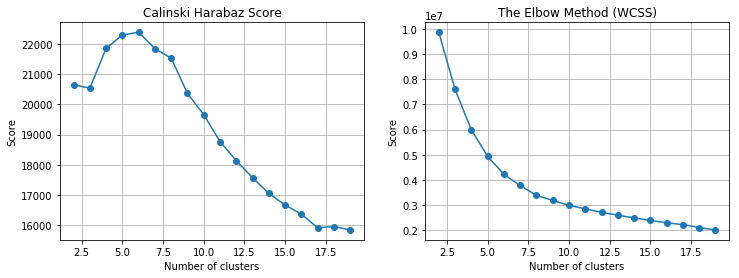

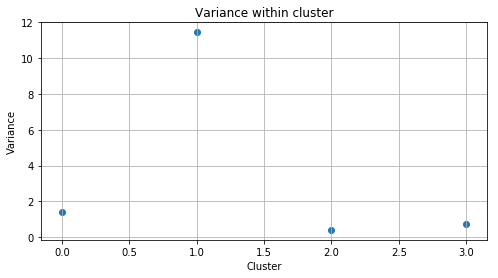

new :  1428
say :  1364
polic :  1247
man :  1174
2014 :  1054


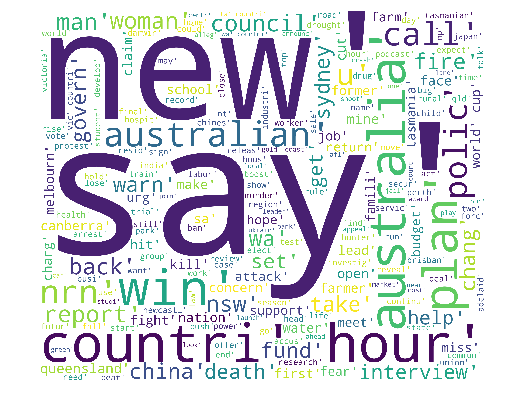

Dataset length: 45425. Year: 2015
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


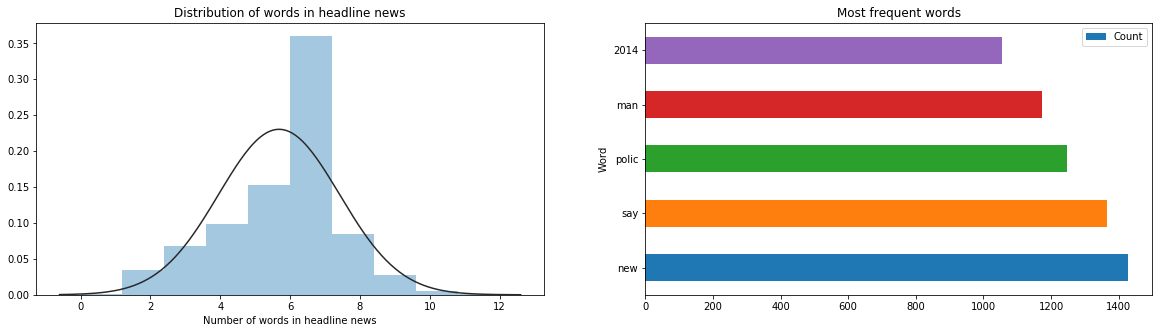

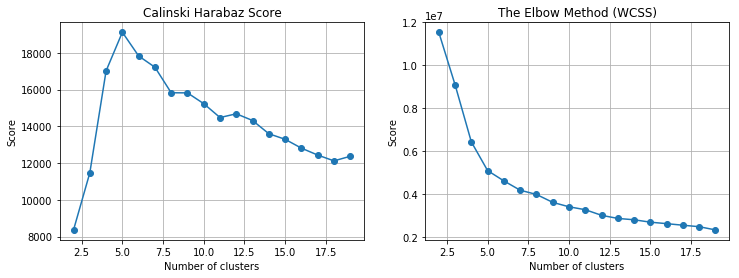

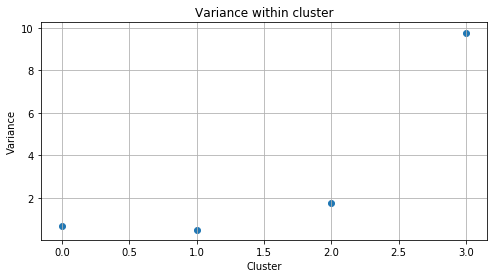

say :  1509
new :  1430
man :  1311
polic :  1268
2015 :  1113


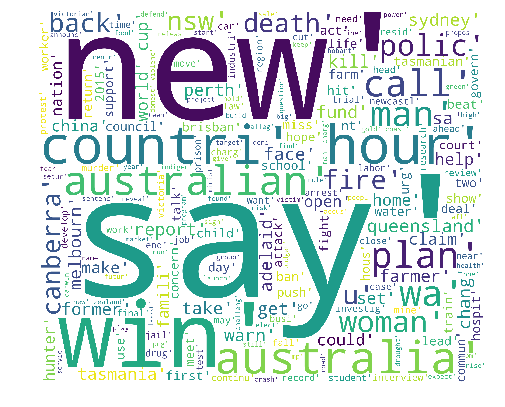

Dataset length: 33400. Year: 2016
Features extractor: word2Vec
Creating Word2Vec Model...


  0%|          | 0/18 [00:00<?, ?it/s]

Max number of clusters for MiniBatchKMeans: 20


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]


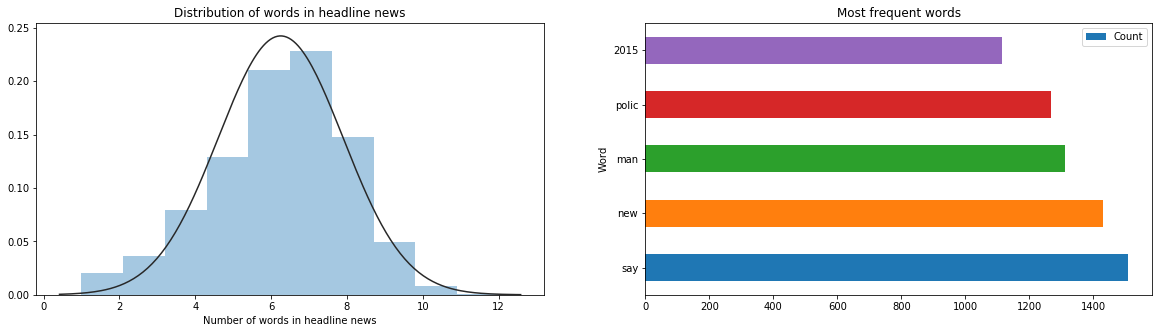

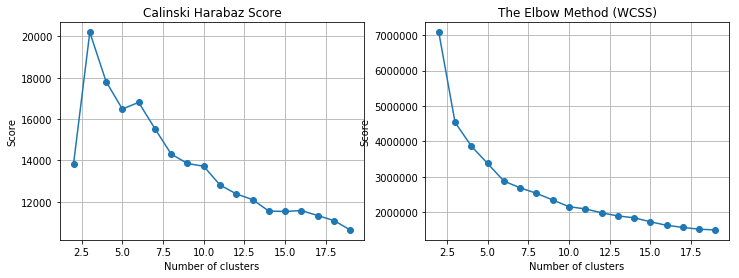

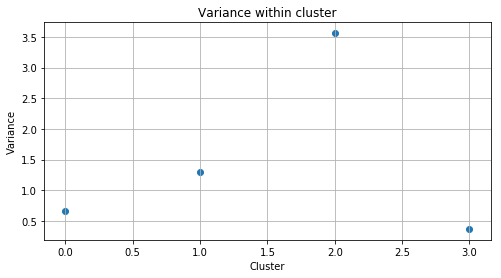

say :  1212
man :  1137
polic :  1054
australia :  1008
new :  958


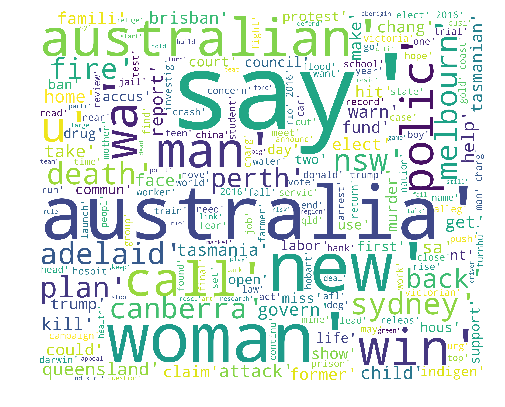

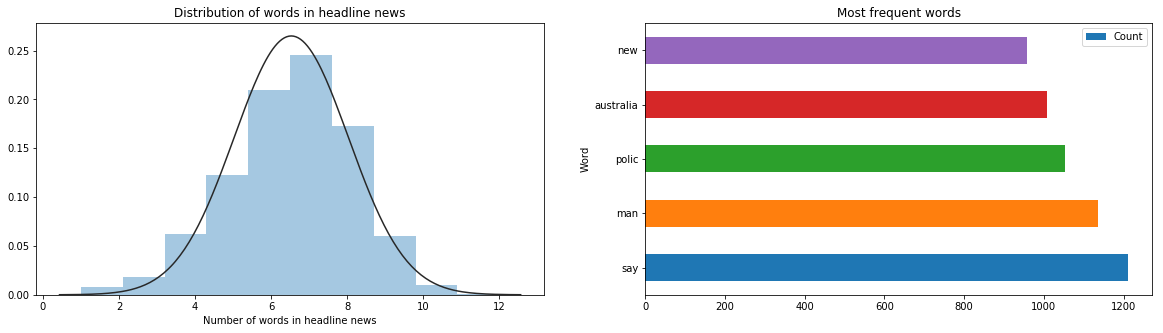

In [23]:
min_year = text['train'].data.publish_date.dt.year.min()
max_year = text['train'].data.publish_date.dt.year.max()

for y in np.arange(min_year, max_year):

    X_train = text['train'].data[text['train'].data.publish_date.dt.year == y]
    
    print('Dataset length: {}. Year: {}'.format(len(X_train), y))
    f_train, _ = extract_features(X_train[col + '_data'].values)
    find_nb_clusters(f_train, kmax=20)
    
    if y != -1:
        plt.savefig('./figs/elbow/' + features_extractor + 'ElbowRule'+'_'+str(y)+'.png')
    else:
        plt.savefig('./figs/elbow/'+ features_extractor +'ElbowRule.png')
        
        
    
    ## Quantitative Analysis
    var = calculate_cluster_variance(f_train)
    
    fig = plt.figure(figsize=(8,4))
    plt.scatter(range(0, 4), var)
    plt.title('Variance within cluster')
    plt.xlabel('Cluster')
    plt.ticklabel_format(style='plain',axis='x',useOffset=False)
    plt.ylabel('Variance')
    plt.grid()
    plt.show()
    fig.savefig('./figs/quantitative_analysis/'+ features_extractor +'Variance_4C.png')

    ## Qualitative Analysis
    procTextCorpus = get_corpus(X_train[col + '_data'])
    procWordCloud = get_wordCloud(procTextCorpus)
    n_print = 5
    word_counter = count_most_frequent_words(procTextCorpus, n_print = n_print)
                          
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(procWordCloud)
    plt.axis('off')
    plt.show()
    fig.savefig('./figs/qualitative_analysis/'+ features_extractor + 'word_clouds.png')
    
    
    fig = plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)

    sns.distplot(X_train['nb_words'],hist=True, kde=False, bins=10, fit=norm)
    plt.title("Distribution of words in headline news")
    plt.xlabel('Number of words in headline news')

    ax = fig.add_subplot(1,2,2)
    lst = word_counter.most_common(n_print)
    df = pd.DataFrame(lst, columns = ['Word', 'Count'])
    plt.title('Most frequent words')
    df.plot(kind="barh",x='Word',y='Count', ax=ax)

    fig.savefig('./figs/qualitative_analysis/'+ features_extractor + 'word_counter.png')

## Cluster analysis for whole dataset

In [24]:
X_train = text['train'].data[col + '_data']

In [25]:
X_train[0]

['unhook', 'brake', 'blame', 'taiwan', 'train', 'disast']

In [26]:
f_train, W2Vmodel = extract_features(X_train)

Features extractor: word2Vec
Creating Word2Vec Model...


/home/renatolr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [27]:
print('Shape of train features:: {}'.format(f_train.shape))

Shape of train features:: (643715, 300)


# Visualizing clusters

In [28]:
kmeans = MiniBatchKMeans(n_clusters = 4, init = 'k-means++',
                         n_init=1,init_size= int(1e3),
                         random_state = 42,batch_size=int(1e3))
kmeans.fit(f_train)
ypred = kmeans.predict(f_train)

In [29]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


def plot_pca(f_train, y_train, nb_clusters = 4):

    palette = np.array(sns.color_palette("hls", nb_clusters))

    pca = PCA(n_components=3)
    result = pca.fit_transform(f_train)
    

    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(result[:, 0], result[:, 1],result[:, 2],
               s=40, c=palette[ypred.astype(np.int)])

    plt.title('Visualization PCA')
    plt.grid()
    plt.show()

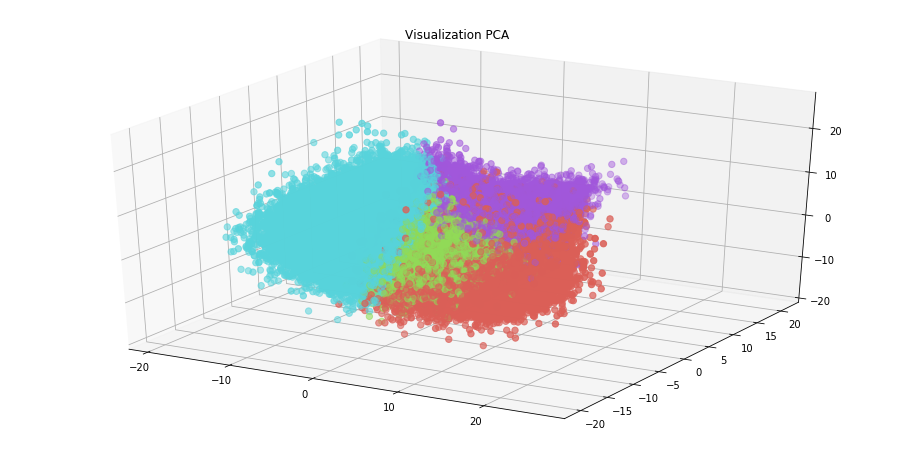

In [30]:
plot_pca(f_train, ypred)

## Words visualization using t-SNE

In [31]:
import bokeh.plotting as bp
from sklearn.manifold import TSNE
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook



def plot_tSNE(model,n_samples = 5000):

    
    #https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm

    output_notebook()
    fig = bp.figure(plot_width=700, plot_height=600, title="A map of " + str(n_samples) + " word vectors",
        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
        x_axis_type=None, y_axis_type=None, min_border=1)


    word_vectors = [model[w] for w in model.wv.vocab.keys()][:n_samples]
    #word_vectors = [token for token in f_matrix_train][0:n_samples]
    word_centroid_map = dict(zip( model.wv.index2word, ypred ))



    tsne_model = TSNE(n_components=2, verbose=1, random_state=23)
    tsne_w2v = tsne_model.fit_transform(word_vectors)

    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = [k for k in model.wv.vocab.keys()][:n_samples]

    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips={"word": "@words"}
    show(fig)

In [32]:
plot_tSNE(W2Vmodel)

Loading BokehJS ...

/home/renatolr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.173s...
[t-SNE] Computed neighbors for 5000 samples in 21.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.985406
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.292572
[t-SNE] Error after 1000 iterations: 2.340618


# Visualizing words in clusters

In [33]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( W2Vmodel.wv.index2word, ypred ))

# For the first 5 clusters
for cluster in range(0,4):
    
    print (f"\n Cluster {cluster}")
    words = []
    for key, value in word_centroid_map.items():
        if( value == cluster ):
            words.append(key)

    print(f'{words[:10]}')


 Cluster 0
['plan', 'council', 'court', 'win', 'report', 'face', 'death', 'nsw', 'chang', 'health']

 Cluster 1
['polic', 'new', 'say', 'charg', 'u', 'back', 'kill', 'australia', 'woman', 'warn']

 Cluster 2
['man', 'call', 'fire', 'crash', 'hit', 'child', 'day', 'miss', 'help', 'group']

 Cluster 3
['govt', 'urg', 'fund', 'water', 'australian', 'qld', 'attack', 'take', 'sydney', 'home']


# Quantitative Cluster Analysis

In [34]:
var = calculate_cluster_variance(f_train)

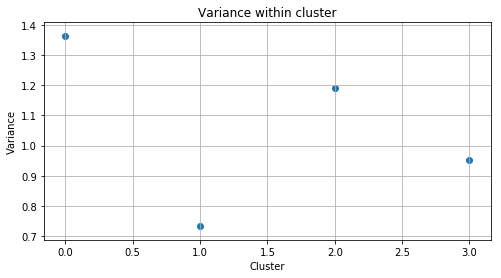

In [35]:
plt.figure(figsize=(8,4))
plt.scatter(range(0, 4), var)
plt.title('Variance within cluster')
plt.xlabel('Cluster')
plt.ticklabel_format(style='plain',axis='x',useOffset=False)
plt.ylabel('Variance')
plt.grid()
plt.show()
plt.savefig('./Variance_4C.png')

In [36]:
procTextCorpus = get_corpus(text['train'].data['headline_text_data'])

### Word Cloud Visualization

In [37]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [38]:
procWordCloud = get_wordCloud(procTextCorpus)

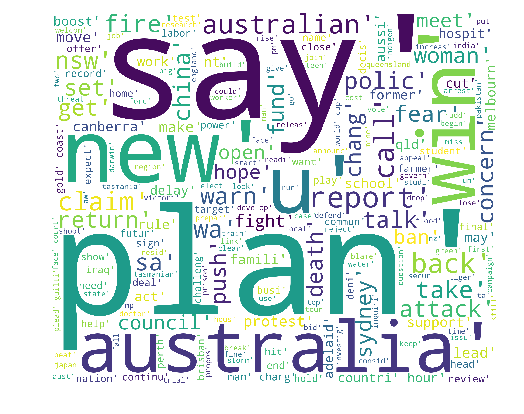

In [39]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(procWordCloud)
plt.axis('off')
plt.show()
fig.savefig('./figs/all_data_word_clouds.png')

### Most frequent words

In [40]:
word_counter = count_most_frequent_words(procTextCorpus)

polic :  21178
new :  17287
man :  17060
say :  14675
plan :  13268


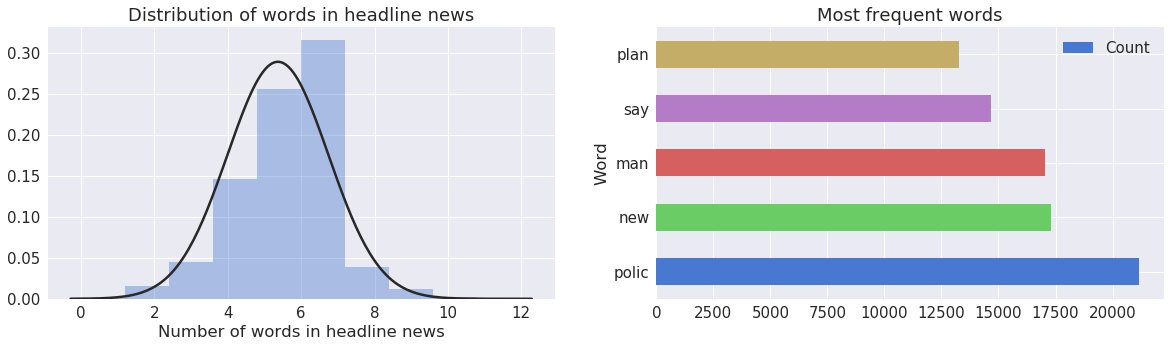

In [41]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)

sns.distplot(text['train'].data['nb_words'],hist=True, kde=False, bins=10, fit=norm)
plt.title("Distribution of words in headline news")
plt.xlabel('Number of words in headline news')

ax = fig.add_subplot(1,2,2)
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
plt.title('Most frequent words')
df.plot(kind="barh",x='Word',y='Count', ax=ax)